In [1]:
import torch
from torch import Tensor
from jaxtyping import Float, Int
from typing import List, Optional, Tuple
import sys
from pympler import asizeof
import multiprocessing

from request_patching import request_patch_one_pair
from models import get_model_from_name
from plots import plot_request_patching_accuracy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device =', device)
torch.set_grad_enabled(False)

# List all available GPUs
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")

else:
    print("CUDA is not available. Listing CPUs instead.")
    print(multiprocessing.cpu_count())

/home/jsalle/.conda/envs/athena_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device = cpu
CUDA is not available. Listing CPUs instead.
48


In [2]:
# Happy
context_1 = '''Bob: Hey Alice, how was your day today?
Alice: Oh, Bob, it was fantastic! I'm still riding the high from it all!
Bob: That sounds wonderful! What happened to make it so great?
Alice: Well, for starters, the weather was absolutely perfect. Not too hot, not too cold, just the kind of day you want to bottle up and keep forever. And then, on my way to work, my favorite song played on the radio. It felt like a sign that the day was going to be amazing.
Bob: I love when that happens! It's like the universe is giving you a personal thumbs up. What else happened?
Alice: Oh, it gets better. When I got to work, I found out that I received the promotion I've been hoping for. It was such a surprise! I've worked so hard for this, Bob, and it finally paid off.
Bob: Alice, that's incredible news! Congratulations on the promotion! You totally deserve it.
Alice: Thank you so much! And there's more. During lunch, I went out with a few colleagues to celebrate, and we ended up having the best time. The food was delicious, and the company was even better.
Bob: Sounds like a perfect day from start to finish.
Alice: It really was. And to cap it all off, when I got home, I found a package waiting for me. The book I've been wanting to read for months was finally released, and my copy arrived. I can't wait to dive into it.
Bob: Wow, what a day! You've got the promotion, great food, good company, and a new book. It's like everything aligned for you today.
Alice: In one word, I was so "'''

# Angry
context_2 = '''Bob: Hey Alice, how was your day?
Alice: Oh, don't even get me started. It was absolutely infuriating!
Bob: Really? What happened that got you so angry?
Alice: Where do I even begin? First, the traffic was a nightmare. I was stuck in my car for what felt like an eternity. And then, when I finally got to work, the coffee machine was broken. Can you believe it? No coffee!
Bob: That sounds rough. No coffee can definitely start the day on a wrong note.
Alice: Exactly! And as if that wasn't enough, my computer decided to crash right before I was about to save a crucial report. Hours of work just vanished. I had to start all over again.
Bob: That's terrible, Alice. I'm really sorry to hear that. Computers can be so unreliable when you need them the most.
Alice: And to top it all off, during lunch, I spilled my meal all over my new shirt. It's like the universe was conspiring against me today. I'm just so fed up with everything!
Bob: I can only imagine how frustrating all of that must have been. If there's anything I can do to help or if you need someone to vent to, I'm here for you.
Alice: In one word, I was so "'''

In [7]:
model, tokenizer = get_model_from_name('pythia-2.8b')

token_per_layer = request_patch_one_pair(context_1="Bob is happy; Alice is angry. Bob feels",
                                         context_2="Bob is sad; Alice is joyful. Alice feels",
                                         model=model,
                                         tokenizer=tokenizer,
                                         details=True)

# Expected result: joyful -> sad -> angry

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


context_1: Bob is happy; Alice is angry. Bob feels
context_2: Bob is sad; Alice is joyful. Alice feels


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
/home/jsalle/.conda/envs/athena_venv/lib/python3.9/site-packages/transformers/generation/utils.py:1141: UserWarning: Input length of input_ids is 11, but `max_length` is set to 11. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  sad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  sad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  sad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  sad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  sad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  sad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  sad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  sad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  sad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  sad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  sad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  sad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  sad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  sad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  sad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  sad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  bad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  bad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  bad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  bad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  bad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  bad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  bad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  bad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  bad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  bad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  bad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  bad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  bad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  bad


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


last_str_token  bad
last_str_token  bad
[' sad', ' sad', ' sad', ' sad', ' sad', ' sad', ' sad', ' sad', ' sad', ' sad', ' sad', ' sad', ' sad', ' sad', ' sad', ' sad', ' bad', ' bad', ' bad', ' bad', ' bad', ' bad', ' bad', ' bad', ' bad', ' bad', ' bad', ' bad', ' bad', ' bad', ' bad', ' bad']


Number of stories: 5
Number of requests: 2


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/home/jsalle/.conda/envs/athena_venv/lib/python3.9/site-packages/transformers/generation/utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/jsalle/.conda/envs/athena_venv/lib/python3.9/site-packages/transformers/generation/utils.py:1141: UserWarning: Input length of input_ids is 195, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 

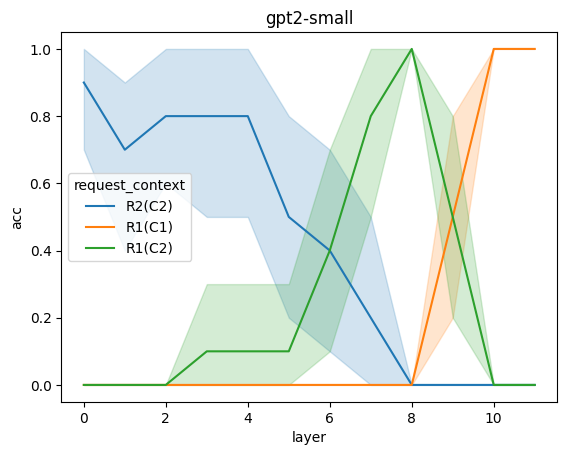

In [2]:
fig = plot_request_patching_accuracy(model_name='gpt2-small',
                                     savefig=True)